# Prior distributions of epidemiological parameters in renewal models

This notebook explores what kind of prior distributions we should set for key parameters calibrated in renewal models

Mostly the focus is on setting prior distributions for the parameters that govern the distirbution of the generation interval and delay distributions, such as reporting delays that link incidence to the reporting of notifications.

Many

This paper using epinow2 uses normal priors on mean and SD: https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1010405#pcbi.1010405.s001 
although no idea where exactly they get these numbers from  in the paper they say they use as supporting evidence

## Generation intervals and how they are implemented in other renewal models

### What is the generation interval?

The generation interval (GT) - *was going to add some text outlining what is and what we assume it represents in these models or might just remove.

The generation interval is typically modelled as a gamma distribution. Studies that aim to estimate the generation interval typically do so  

Ass such, within renewal models generation times are typically implemented as a gamma distributions. Many approaches fix the gamma distribution parameters based on evidence from the literature - usually by just setting the mean and standard deviation based on the estimates that come from fitting distributions to data as described above.
For example; Flaxman et al. (https://www.nature.com/articles/s41586-020-2405-7) and Faria et al. (https://www.science.org/doi/10.1126/science.abh2644#supplementary-materials)

Epinow2 allows for the mean and SD parameters of the gamma distributed GT to be claibrated during model fitting and based on their code they seem to always specifiy normal priors around these quantities. Published example paper using Epinow2 Bosse et al. (https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1010405) and 

### Estimates the generation interval for COVID-19


Best estimates of the generation time are likely those taken early in an epidemic - before there is significant depletion of susceptibles and before the implementation of public health and social measures (PHSM) -> both of which will lead to contraction of the generation interval.

Chen et al. (https://www.nature.com/articles/s41467-022-35496-8#Sec9) in 2022 re-examined transmission pair data from early in the COVID-19 outbreak in China (Jan-Feb 2020) to estimate the generation time distribution. Under the assumption that the generation time follows a gamma distribution, Chen et al. generated estimates of the GT over several time windows during that period. Prior to the implementation of PHSMs, they estimated a mean generation time 7.27 days (95% CI 6.42 to 8.07) with a standard deviation of 3.81 days (95% CI 2.84 to 4.80). 

One approach to incorporating this evidence would be to just fix the parameters of gamma distributed GT at these estimated values.

However, to include more uncertainty we could set the mean and sd parameters of our gamma distributed GT as prior distributions and include them in calibration, and thus better explore uncertainty around these values and their influence on model dynamics.

Setting prior distributions for these parameters based on the prior information we have is the next question.

Although they are the mean and sd of a gamma distributed GT - these parameters themsevles are not necessarily gamma distributed. In Chen et al., the mean is estimated based on maximum likelihood and the 95% CI are constructed using boostrapped sampling. I believe, The central limit theorem still applies here - and thus the assumption is that these parameters of the GT distribution (being the mean and sd) are approximately normally distributed. 

In [1]:
# Define convienence function for computing the sd of the mean and the sd, based on the 95%CI
# If we assume the mean and sd are normally distributed - then we know that the 95% CI are ~+/- 2 SD of the mean and therefore we can roughly calculate what the SD should be for these values
def compute_parameter_sd(mean, mean_ui, sd, sd_ui):
    mean_sd = (mean_ui - mean)/2
    sd_sd = (sd_ui - sd)/2
    return mean_sd, sd_sd


In [2]:
# Compute what the SD should be to specify a normal distribution prior for the mean and SD based on the evidence
compute_parameter_sd(7.27, 8.07, 3.81, 4.80)

(0.40000000000000036, 0.4949999999999999)

The results of this is that the we should be able to specify a normal prior for both the mean and SD of the GT gamma distribution:
mean ~ N(7.3, 0.4)
SD ~ N (3.8, 0.5)

## Exploration of priors for generation time

The code that follows is adapted (essentially copied) from the covid Malaysia notebook to implement these more informative priors.

In [3]:
from jax import jit, random
import pandas as pd
from datetime import datetime, timedelta
import numpyro
from numpyro import distributions as dist
from numpyro import infer
import arviz as az
from plotly.express.colors import qualitative as qual_colours
import numpy as np
import seaborn as sns

from estival.sampling import tools as esamp

from emu_renewal.process import CosineMultiCurve
from emu_renewal.distributions import GammaDens
from emu_renewal.renew import RenewalModel
from emu_renewal.outputs import get_spaghetti_from_params, get_quant_df_from_spaghetti
from emu_renewal.outputs import plot_uncertainty_patches, plot_post_prior_comparison
from emu_renewal.calibration import StandardCalib

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [29]:
# Specify fixed parameters and get calibration data
proc_update_freq = 14
init_time = 50
mys_data = pd.read_csv("https://github.com/monash-emu/wpro_working/raw/main/data/new_cases.csv", index_col=0)["MYS"]
mys_data.index = pd.to_datetime(mys_data.index)
pop = 33e6
analysis_start = datetime(2021, 3, 1)
analysis_end = datetime(2021, 11, 1)
init_start = analysis_start - timedelta(init_time)
init_end = analysis_start - timedelta(1)
select_data = mys_data.loc[analysis_start: analysis_end]
init_data = mys_data.loc[init_start: init_end]

In [28]:
renew_model = RenewalModel(33e6, analysis_start, analysis_end, proc_update_freq, CosineMultiCurve(), GammaDens(), 50, init_data, GammaDens())

In [30]:
# Define parameter ranges
priors = {
    "gen_mean": dist.TruncatedNormal(7.3, 0.4, low=0.1),
    "gen_sd": dist.TruncatedNormal(3.8, 0.5, low=0.1),
    "cdr": dist.Beta(4.0, 10.0),
    "rt_init": dist.Normal(0.0, 0.25),
    "report_mean": dist.Uniform(8.0, 12.0),
    "report_sd": dist.Uniform(3.0, 6.0),
}

In [23]:
calib = StandardCalib(renew_model, priors, select_data)
kernel = infer.NUTS(calib.calibration, dense_mass=True, init_strategy=infer.init_to_uniform(radius=0.5))
mcmc = infer.MCMC(kernel, num_chains=2, num_samples=1000, num_warmup=1000)
mcmc.run(random.PRNGKey(1))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [24]:
idata = az.from_dict(mcmc.get_samples(True))
idata_sampled = az.extract(idata, num_samples=200)
sample_params = esamp.xarray_to_sampleiterator(idata_sampled)

In [31]:
def get_full_result(gen_mean, gen_sd, proc, cdr, rt_init, report_mean, report_sd):
    return renew_model.renewal_func(gen_mean, gen_sd, proc, cdr, rt_init, report_mean, report_sd)

full_wrap = jit(get_full_result)
spaghetti = get_spaghetti_from_params(renew_model, sample_params, full_wrap)
quantiles_df = get_quant_df_from_spaghetti(renew_model, spaghetti, quantiles=[0.05, 0.5, 0.95])
plot_uncertainty_patches(quantiles_df, select_data, qual_colours.Plotly).update_layout(showlegend=False)

In [32]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cdr,0.241,0.093,0.104,0.419,0.007,0.005,175.0,100.0,1.01
dispersion,0.142,0.007,0.129,0.154,0.000,0.000,901.0,1533.0,1.00
gen_mean,7.356,0.408,6.596,8.110,0.010,0.007,1627.0,1370.0,1.00
gen_sd,4.256,0.481,3.386,5.192,0.012,0.008,1668.0,1349.0,1.00
proc[0],0.742,0.094,0.576,0.918,0.004,0.003,559.0,1352.0,1.01
proc[1],0.152,0.096,-0.033,0.332,0.004,0.003,623.0,1314.0,1.00
proc[2],0.075,0.091,-0.078,0.260,0.003,0.002,785.0,1368.0,1.00
proc[3],-0.162,0.093,-0.343,0.002,0.003,0.002,1380.0,1447.0,1.00
proc[4],0.256,0.093,0.089,0.447,0.002,0.002,1630.0,1377.0,1.00
proc[5],-0.514,0.095,-0.680,-0.321,0.002,0.002,1791.0,1210.0,1.00


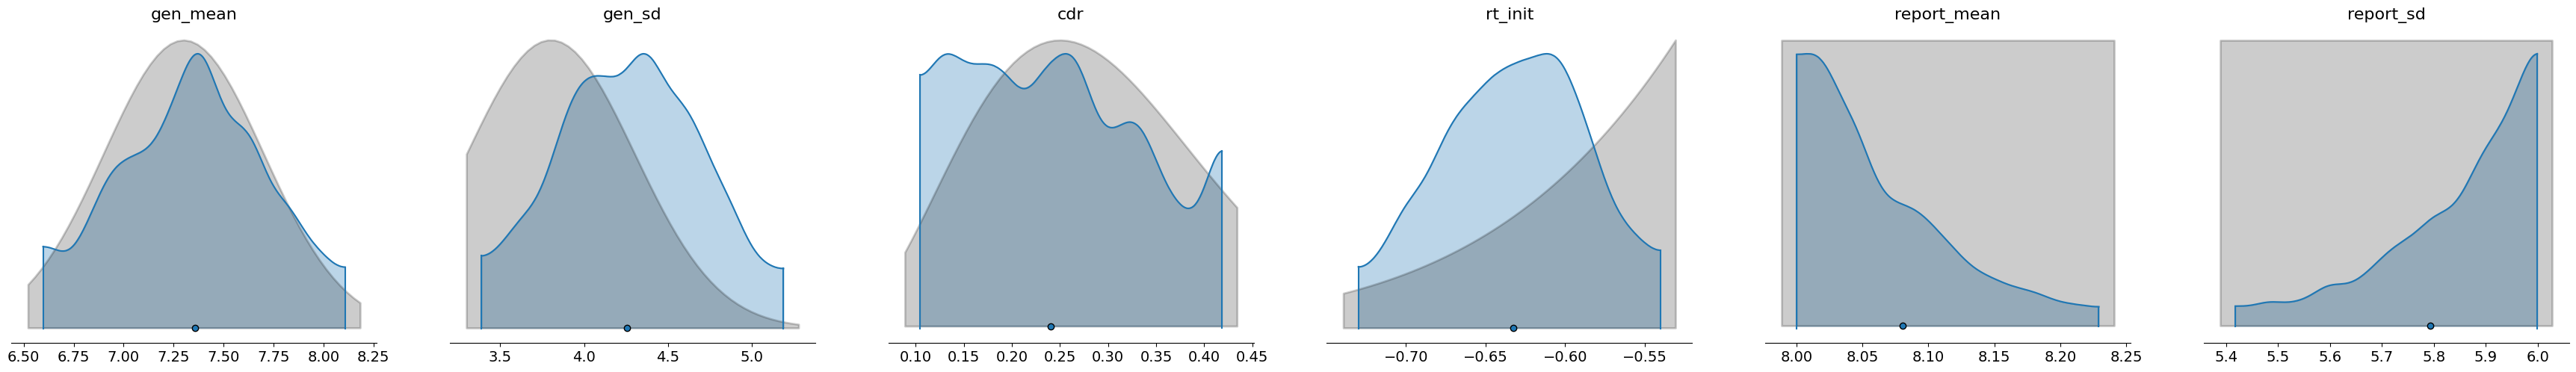

In [27]:
plot_post_prior_comparison(idata, list(priors.keys()), priors);